[View in Colaboratory](https://colab.research.google.com/github/BUPT/ai-ml.club/blob/master/code/CAIC_9_Example_of_VAE_Mnist2.ipynb)

# CAIC #9 - Example of VAE : Mnist2
与Mnist1相比，这个模型可以手动控制输出的数字。
该原理是

### Reference:
- https://github.com/bojone/vae

### Author: [824zzy](https://github.com/824zzy)


## Demo: Mnist2

### 导入库

In [17]:
!apt-get install graphviz
!pip install pydot graphviz easydict

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
0 upgraded, 30 newly installed, 0 to remove and 12 not upgraded.
Need to get 4,154 kB o

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical,plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


### Hyperparameters and Datasets

In [0]:
batch_size = 100
original_dim = 784
latent_dim = 2 # 隐变量取2维只是为了方便后面画图
intermediate_dim = 256
epochs = 100
epsilon_std = 1.0
num_classes = 10

In [3]:
# 加载MNIST数据集
(x_train, y_train_), (x_test, y_test_) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train = to_categorical(y_train_, num_classes)
y_test = to_categorical(y_test_, num_classes)

11493376/11490434 [==============================] - 2s 0us/step


### Main Model

In [0]:
# VAE的输入1
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
# 算p(Z|X)的均值和方差
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
# VAE的输入2
y = Input(shape=(num_classes,)) # 输入类别
yh = Dense(latent_dim)(y) # 这里就是直接构建每个类别的均值

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 重参数层，相当于给输入加入噪声
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [0]:
# 解码层，也就是生成器部分
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [7]:
# 建立模型
vae = Model([x, y], [x_decoded_mean, yh])
# xent_loss是重构loss，kl_loss是KL loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)

# 只需要修改K.square(z_mean)为K.square(z_mean - yh)，也就是让隐变量向类内均值看齐
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean - yh) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

# add_loss是新增的方法，用于更灵活地添加各种loss
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Output "dense_6" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_6" during training.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Output "dense_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_4" during training.
  # This is added back by InteractiveShellApp.init_path()


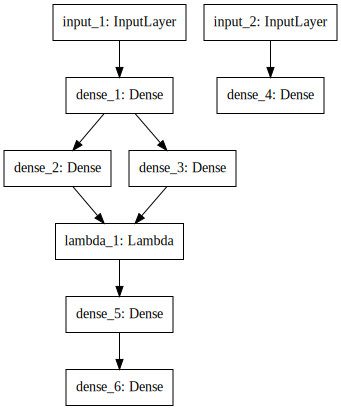

In [9]:
SVG(model_to_dot(vae).create(prog='dot', format='svg'))

In [8]:
vae.fit([x_train, y_train], 
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test, y_test], None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 12s 206us/step - loss: 191.1209 - val_loss: 172.7051
Epoch 2/100
60000/60000 [==============================] - 11s 180us/step - loss: 169.7123 - val_loss: 166.2568
Epoch 3/100
60000/60000 [==============================] - 11s 177us/step - loss: 163.8716 - val_loss: 161.6902
Epoch 4/100
60000/60000 [==============================] - 11s 176us/step - loss: 160.5609 - val_loss: 159.7217
Epoch 5/100
60000/60000 [==============================] - 11s 176us/step - loss: 158.5281 - val_loss: 157.9691
Epoch 6/100
60000/60000 [==============================] - 11s 177us/step - loss: 157.0379 - val_loss: 156.4214
Epoch 7/100
60000/60000 [==============================] - 11s 178us/step - loss: 155.8835 - val_loss: 155.6207
Epoch 8/100
60000/60000 [==============================] - 11s 176us/step - loss: 154.9917 - val_loss: 154.7695
Epoch 9/100
60000/60000 [=============================

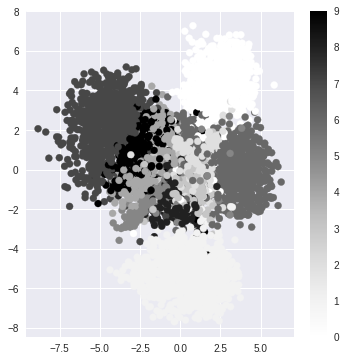

In [9]:
# 构建encoder，然后观察各个数字在隐空间的分布
encoder = Model(x, z_mean)

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test_)
plt.colorbar()
plt.show()

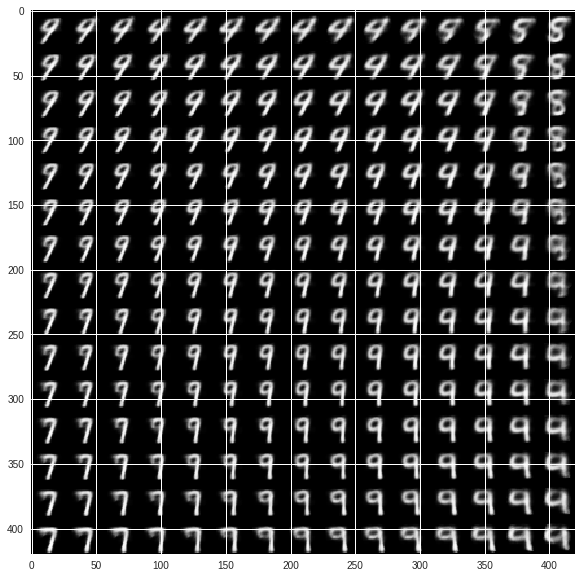

In [10]:
# 构建生成器
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# 输出每个类的均值向量
mu = Model(y, yh)
mu = mu.predict(np.eye(num_classes))

# 观察能否通过控制隐变量的均值来输出特定类别的数字
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

output_digit = 9 # 指定输出数字

# 用正态分布的分位数来构建隐变量对
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) + mu[output_digit][1]
grid_y = norm.ppf(np.linspace(0.05, 0.95, n)) + mu[output_digit][0]

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()